<a href="https://colab.research.google.com/github/Nishr27/CANN/blob/main/CANN_for_Mooney_Rivlin_material.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Training and Test Data for CANN

We start by preparing data according to the Mooney-Rivlin model using the following equation, for generating the strain energy function:

- psi = ci0*(I - 3)**i + c0i*(II - 3)**i
we have the material parameters given as per the Table 1 in the research paper Linka et al.

We write the functions that are used throughout the program. 

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn.preprocessing as StandardScaler

In [2]:
def deformation_gradient(batch_size):
  """
  Returns the Deformation Gradients generated for three types of loading: Uniaxial Tension Loading, Equi-Biaxial Loading and Pure Shear Loading

  """
  # Generating random stretch values between 1 to 7
  stretch = tf.random.uniform(shape=[batch_size], minval=1, maxval=7, dtype=tf.float32, seed=42)
  #stretch = tf.Variable(np.linspace(1.2, 7.0, num=batch_size, endpoint=True, dtype=np.float32))
  sqrt_stretch = tf.math.sqrt(stretch)
  stretch_sqr = tf.math.square(stretch)

  # Deformation Gradient for Uniform Tension Loading
  uniform_tension = tf.Variable(tf.zeros(shape=[batch_size, 3, 3]))
  for i in range(0, batch_size):
    uniform_tension[i, 0, 0].assign(stretch[i])
    uniform_tension[i, 1, 1].assign(1/sqrt_stretch[i])
    uniform_tension[i, 2, 2].assign(1/sqrt_stretch[i])
  
  # Deformation Gradient for Equi-Biaxial Loading
  eq_biaxial = tf.Variable(tf.zeros(shape=[batch_size, 3, 3]))
  for i in range(0, batch_size):
    eq_biaxial[i, 0, 0].assign(stretch[i])
    eq_biaxial[i, 1, 1].assign(stretch[i])
    eq_biaxial[i, 2, 2].assign(1/stretch_sqr[i])
  
  # Deformation Gradient for Pure Shear Loading
  pure_shear = tf.Variable(tf.eye(3, batch_shape=[batch_size], dtype=tf.float32))
  for i in range(0, batch_size):
    pure_shear[i, 0, 0].assign(stretch[i])
    pure_shear[i, 1, 1].assign(1/stretch[i])
  
  return uniform_tension, eq_biaxial, pure_shear, stretch  

In [3]:
def strain_energy(first_inv, second_inv):
  """ 
  This function provides the strain energy function based on the Mooney-Rivlin rule, given the first and second strain invariants (Ic and IIc).
  We also define the material constants ci0 and c0i here.
  This can then be used for training the CANN using the invariants as inputs and the energy function as the label for a certain pair of invariants.

  """
  # Material Constants
  ci0 = tf.constant([1.6e-1, -1.4e-3, 3.9e-5])
  c0i = tf.constant([1.5e-2, -2.0e-6, 1.0e-10])
  
  # Getting the batch size for the data
  batch_size = first_inv.shape[0]

  # Initializing the psi function with zeros
  psi = tf.Variable(tf.zeros(batch_size))

  # Calculation of strain energy function
  for i in range(0, batch_size):
    sum = 0
    
    for j in range(0, 3):
      sum = sum + ci0[j] * ((first_inv[i] - 3)**(j+1)) + c0i[j] * ((second_inv[i] - 3)**(j+1))

    psi[i].assign(sum)

  # Return the calculated energy function
  return psi

In [4]:
def right_Cauchy_Green_tensor(def_gradient):
  """
  Function formulates the right Cauchy-Green Tensor from the Deformation Gradient
  
  """
  # Right Cauchy-Green Tensor C from Deformation Gradient
  C = tf.linalg.matmul(def_gradient, def_gradient, transpose_a=True)

  return C

In [5]:
def strain_invariants(C):
  """ 
  This function calculates the strain/stress invariants given the right Cauchy-Green Tensor.
  
  """
  # First Strain Invariant
  first_inv = tf.linalg.trace(C)

  # Second Strain Invariant
  second_inv = 0.5*((tf.math.square(first_inv)) - tf.linalg.trace(tf.linalg.matmul(C, C, transpose_a=True)))

  return first_inv, second_inv  

In [6]:
def second_Piola_Kirchhoff_stress(psi, C):
  """
  This function calculate the second Piola-Kirchhoff stress by taking the Gradient of the strain energy w.r.t right Cauchy Green Tensor
  
  """
  with tf.GradientTape() as tape:
    tape.watch(C)
    I = tf.linalg.trace(C)
    II = 0.5*( (tf.linalg.trace(C)**2) - (tf.linalg.trace(tf.linalg.matmul(C, C, transpose_a=True))) )
    psi = 1.6e-1*(I - 3) + 1.5e-2*(II - 3) + (-1.4e-3)*((I - 3)**2) + (-2.0e-6)*((II - 3)**2) + (3.9e-5)*((I - 3)**3) + (1.0e-10)*((II - 3)**3)

  return 2*tape.gradient(psi, C)

In [7]:
def first_Piola_Kirchhoff_stress(S, def_grad):
  """
  This function returns the first Piola-Kirchhoff (nominal) stress by multiplying the Deformation Gradient and the second Piola-Kirchhoff stress
  """
  return tf.linalg.matmul(def_grad, S)

In [8]:
def standard_scaling(first_inv, second_inv):
  from sklearn.preprocessing import StandardScaler

  scaler = StandardScaler()
  first_inv_scaled = scaler.fit_transform(first_inv)
  second_inv_scaled = scaler.transform(second_inv)

  return first_inv_scaled, second_inv_scaled

In [9]:
def split_train_test(first_inv, second_inv, psi):
  """ 
  Splitting the Strain invariant data into Training and Test Sets with a Test size of 0.2
  """
  np.random.seed(42)
  shuffled_indices = np.random.permutation(first_inv.shape[0])
  test_set_size = int(first_inv.shape[0] * 0.2)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]

  return tf.gather(first_inv, train_indices), tf.gather(first_inv, test_indices), tf.gather(second_inv, train_indices), tf.gather(second_inv, test_indices), tf.gather(psi, train_indices), tf.gather(psi, test_indices)

In [10]:
def CANN_model():
  """
  ANN Model 
  
  """  
  I = keras.layers.Input(shape=[1], name="I")
  II = keras.layers.Input(shape=[1],name="II")
  concat = keras.layers.concatenate([I, II])
  hidden0 = keras.layers.Dense(10, activation="relu")(concat)
  Psi = keras.layers.Dense(1, activation="relu", name="Psi")(hidden0)

  model = keras.models.Model(inputs=[I, II], outputs=[Psi])
  
  return model

#Body of the Main Function

**Generating the Deformation gradient values for the three load cases**

In [11]:
# Setting the random seed
tf.random.set_seed(42)

# Generating deformation gradients for the various load cases: Uniaxial Tension (UT), Equi-biaxial Tension (EBT) and Pure Shear (PS)
# Also returning the stretches 
UT, EBT, PS, stretch = deformation_gradient(15)

# Checking the examples generated
print("Examples of the Deformation Gradients generated are: \n\n UT = ", UT[0], "\n\n EBT = ", EBT[0], "\n\n PS = ", PS[0], "\n\n Stretch = ", stretch)

Examples of the Deformation Gradients generated are: 

 UT =  tf.Tensor(
[[3.4978168 0.        0.       ]
 [0.        0.5346893 0.       ]
 [0.        0.        0.5346893]], shape=(3, 3), dtype=float32) 

 EBT =  tf.Tensor(
[[3.4978168  0.         0.        ]
 [0.         3.4978168  0.        ]
 [0.         0.         0.08173459]], shape=(3, 3), dtype=float32) 

 PS =  tf.Tensor(
[[3.4978168 0.        0.       ]
 [0.        0.2858926 0.       ]
 [0.        0.        1.       ]], shape=(3, 3), dtype=float32) 

 Stretch =  tf.Tensor(
[3.4978168 2.6114898 3.878099  3.187428  6.7282686 6.651188  4.689004
 3.1505287 4.5616145 2.2930658 1.4647102 4.475279  2.7508237 2.603082
 3.2207475], shape=(15,), dtype=float32)


**Calculating the strain invariants from the generated deformation gradients**

In [12]:
# Right Cauchy-Green Tensor from the Deformation Gradient
C_ut = right_Cauchy_Green_tensor(UT)
C_ebt = right_Cauchy_Green_tensor(EBT)
C_ps = right_Cauchy_Green_tensor(PS)

print("Right Cauchy Green Tensors: \n\n UT = ", C_ut[0], "\n\n EBT = ", C_ebt[0], "\n\n PS = ", C_ps[0])

Right Cauchy Green Tensors: 

 UT =  tf.Tensor(
[[12.234722    0.          0.        ]
 [ 0.          0.28589267  0.        ]
 [ 0.          0.          0.28589267]], shape=(3, 3), dtype=float32) 

 EBT =  tf.Tensor(
[[1.2234722e+01 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.2234722e+01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 6.6805431e-03]], shape=(3, 3), dtype=float32) 

 PS =  tf.Tensor(
[[12.234722    0.          0.        ]
 [ 0.          0.08173458  0.        ]
 [ 0.          0.          1.        ]], shape=(3, 3), dtype=float32)


In [13]:
# Strain Invariants for the three cases
I_ut, II_ut = strain_invariants(C_ut) 
I_ebt, II_ebt = strain_invariants(C_ebt)
I_ps, II_ps = strain_invariants(C_ps)

# Examples of the strain invariants 
print("Strain Invariants for Uniaxial Tension: \n\n First Invariant = ", I_ut, "\n\n Second Invariant = ", II_ut, "\n\n")
print("Strain Invariants for Equi-Biaxial Tension: \n\n First Invariant = ", I_ebt, "\n\n Second Invariant = ", II_ebt, "\n\n")
print("Strain Invariants for Pure Shear: \n\n First Invariant = ", I_ps, "\n\n Second Invariant = ", II_ps, "\n\n")

Strain Invariants for Uniaxial Tension: 

 First Invariant =  tf.Tensor(
[12.806507   7.5857253 15.555368  10.787162  45.566856  44.538998
 22.413286  10.560644  21.246769   6.130345   3.5108337 20.47502
  8.294086   7.544356  10.994188 ], shape=(15,), dtype=float32) 

 Second Invariant =  tf.Tensor(
[ 7.0773544  5.36961    7.8226776  6.473278  13.478882  13.324951
  9.423492   6.4017982  9.17131    4.776308   3.3955388  9.000488
  5.6338005  5.3537426  6.5378914], shape=(15,), dtype=float32) 


Strain Invariants for Equi-Biaxial Tension: 

 First Invariant =  tf.Tensor(
[24.476126  13.661259  30.083725  20.329082  90.53969   88.47711
 43.975582  19.861813  41.61896   10.55247    4.5080185 40.058735
 15.151527  13.573851  20.755722 ], shape=(15,), dtype=float32) 

 Second Invariant =  tf.Tensor(
[ 149.85193    46.804012  226.32411   103.416306 2049.381    1957.0724
  483.50842    98.72363   433.08252    28.028513    5.534875  401.22556
   57.524277   46.209812  107.796364], shape=(15,)

**Calculating the Strain Energy Function from the Strain Invariants**

In [14]:
# Strain Invariants for the three cases
psi_ut = strain_energy(I_ut, II_ut)
psi_ebt = strain_energy(I_ebt, II_ebt)
psi_ps = strain_energy(I_ps, II_ps)

print("Strain Energy Functions for UT, EBT and PS are: \n\n UT = ", psi_ut[0], "\n\n EBT = ", psi_ebt[0], "\n\n PS = ", psi_ps[0])

Strain Energy Functions for UT, EBT and PS are: 

 UT =  tf.Tensor(1.5323132, shape=(), dtype=float32) 

 EBT =  tf.Tensor(5.336738, shape=(), dtype=float32) 

 PS =  tf.Tensor(1.698987, shape=(), dtype=float32)


# Neural Network Model

**Preparing Training and Test sets**

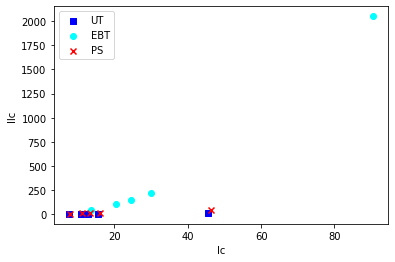

In [15]:
# Plotting the Invariant plane (I-II plane)
plt.scatter(I_ut[:5], II_ut[:5], color="blue", marker="s", label="UT")
plt.scatter(I_ebt[:5], II_ebt[:5], color="cyan", marker="o", label="EBT")
plt.scatter(I_ps[:5], II_ps[:5], color="red", marker="x", label="PS")
plt.xlabel("Ic")
plt.ylabel("IIc")
plt.legend()
plt.show()

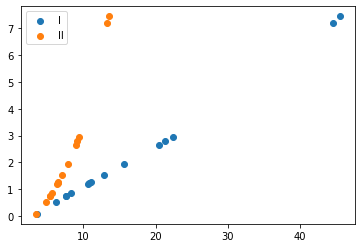

In [16]:
plt.scatter(I_ut, psi_ut, label="I")
plt.scatter(II_ut, psi_ut, label="II")
plt.legend()

In [17]:
I_ut_scaled, II_ut_scaled = standard_scaling(I_ut.numpy().reshape(-1,1), II_ut.numpy().reshape(-1,1))

I_ebt_scaled, II_ebt_scaled = standard_scaling(I_ebt.numpy().reshape(-1,1), II_ebt.numpy().reshape(-1,1))

I_ps_scaled, II_ps_scaled = standard_scaling(I_ps.numpy().reshape(-1, 1), II_ps.numpy().reshape(-1,1))

In [18]:
I_ut_train, I_ut_test, II_ut_train, II_ut_test, psi_ut_train, psi_ut_test = split_train_test(I_ut_scaled, II_ut_scaled, psi_ut)

I_ebt_train, I_ebt_test, II_ebt_train, II_ebt_test, psi_ebt_train, psi_ebt_test = split_train_test(I_ebt, II_ebt, psi_ebt)

I_ps_train, I_ps_test, II_ps_train, II_ps_test, psi_ps_train, psi_ps_test = split_train_test(I_ps, II_ps, psi_ps)

**Building the Neural Network Model**

In [19]:
model = CANN_model()

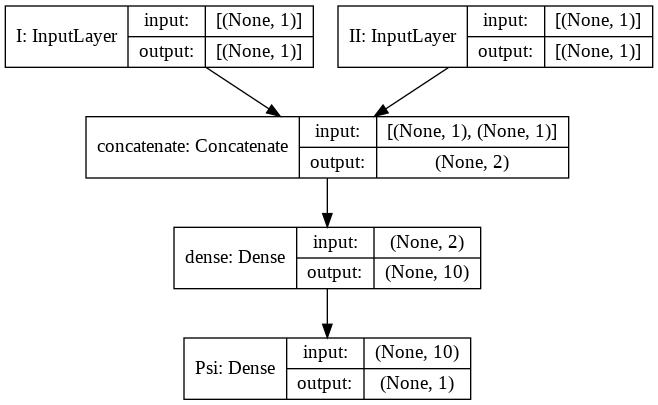

In [20]:
# Checking the construction of the Neural Network
# Activation functions used in all layers are "ReLU"
keras.utils.plot_model(model, show_shapes=True)

In [21]:
# Compiling the Model
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [22]:
I_all = tf.concat([I_ut, I_ebt], axis=0)
print(I_ut_test)
print(I_ebt_test)
I = tf.reshape(I_ut_test, (3,))
print(I)

tf.Tensor(
[[-0.8364769 ]
 [ 0.31686562]
 [-0.2996992 ]], shape=(3, 1), dtype=float32)
tf.Tensor([10.55247  40.058735 24.476126], shape=(3,), dtype=float32)
tf.Tensor([-0.8364769   0.31686562 -0.2996992 ], shape=(3,), dtype=float32)


In [23]:
# Training the Model on the prepared data
history1 = model.fit([I_ut_train, II_ut_train], psi_ut_train, epochs=1000, validation_data=([I_ut_test, II_ut_test], psi_ut_test))

history2 = model.fit([I_ebt_train, II_ebt_train], psi_ebt_train, epochs=1000, validation_data=([I_ebt_test, II_ebt_test], psi_ebt_test))

history3 = model.fit([I_ps_train, II_ps_train], psi_ps_train, epochs=1000, validation_data=([I_ps_test, II_ps_test], psi_ps_test))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step - loss: 0.0332 - val_loss: 0.0221
Epoch 502/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0331 - val_loss: 0.0221
Epoch 503/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0330 - val_loss: 0.0220
Epoch 504/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0329 - val_loss: 0.0220
Epoch 505/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0328 - val_loss: 0.0220
Epoch 506/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.0327 - val_loss: 0.0220
Epoch 507/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.0326 - val_loss: 0.0220
Epoch 508/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0324 - val_loss: 0.0220
Epoch 509/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0323 - val_loss: 0.0220
Epoch 510/1000
1/1 [==============================] - 0

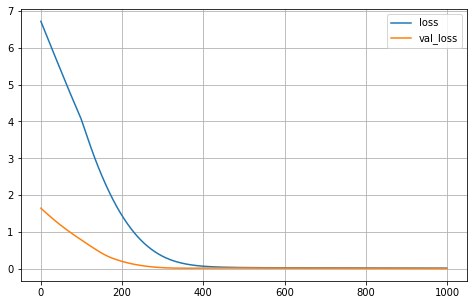

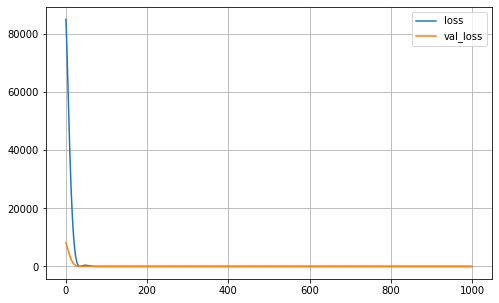

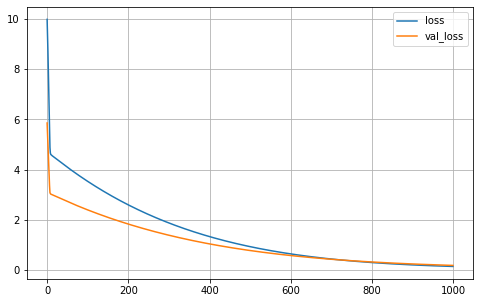

In [24]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [25]:
# Predicting the strain energy outputs for the I, II inputs
results = model.predict([I_ut, II_ut])

#Getting the Stress Values from the Strain Energy Function

In [26]:
# Return the Second Piola Kirchhoff Stress
batch_size = C_ut.shape[0]
S_ut = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ebt = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ps = tf.Variable(tf.zeros([batch_size, 3, 3]))

for i in range(0, batch_size):
  S_ut[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ut[i], C_ut[i,:,:]))
  S_ebt[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt[i], C_ebt[i,:,:]))
  S_ps[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt[i], C_ebt[i,:,:]))

In [27]:
# First Piola-Kirchhoff Stress
P_ut = first_Piola_Kirchhoff_stress(S_ut, UT)
P_ebt = first_Piola_Kirchhoff_stress(S_ebt, EBT)
P_ps = first_Piola_Kirchhoff_stress(S_ps, PS)

In [28]:
# Getting the values for P11
P11_ut = P_ut[:,0,0]
P11_ebt = P_ebt[:,0,0]
P11_ps = P_ps[:,0,0]
print(P11_ut)
print(P11_ebt)
print(P11_ps)

tf.Tensor(
[1.0658603  0.8414261  1.171297   0.9861523  3.461773   3.3265383
 1.4641339  0.97686464 1.4088945  0.7588134  0.5246003  1.3738366
 0.87670904 0.8392835  0.99456155], shape=(15,), dtype=float32)
tf.Tensor(
[ 2.3109348  1.2789661  2.9662473  1.8812209 15.836295  15.217662
  4.977878   1.835593   4.5969825  1.0291852  0.5608648  4.3537564
  1.4049664  1.2717133  1.9233639], shape=(15,), dtype=float32)
tf.Tensor(
[ 2.3109348  1.2789661  2.9662473  1.8812209 15.836295  15.217662
  4.977878   1.835593   4.5969825  1.0291852  0.5608648  4.3537564
  1.4049664  1.2717133  1.9233639], shape=(15,), dtype=float32)


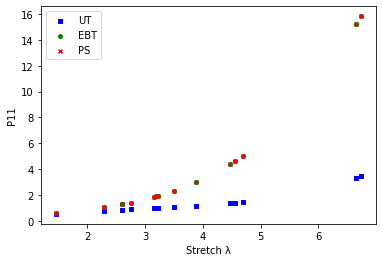

In [29]:
# Plot P11 vs Stretch for all three types of deformations
plt.scatter(stretch, P11_ut, s=15, color="blue", marker="s", label="UT")
plt.scatter(stretch, P11_ebt, s=15, color="green", marker="o", label="EBT")
plt.scatter(stretch, P11_ps, s=15, color="red", marker="x", label="PS")
plt.xlabel("Stretch λ")
plt.ylabel("P11")
plt.legend()
plt.show()

# EBT and PS are almost coinciding in their plots so only one can be seen

**Predicted Stress Values by Model**

In [30]:
#Predicting the Stress Values on the entire DataSet

psi_ut_pred = model.predict([I_ut_scaled, II_ut_scaled]).reshape(batch_size)
psi_ebt_pred = model.predict([I_ebt_scaled, II_ebt_scaled]).reshape(batch_size)
psi_ps_pred = model.predict([I_ps_scaled, II_ps_scaled]).reshape(batch_size)
print(psi_ut_pred)

[1.0578259  0.5819645  1.3348998  0.86403394 4.9130597  4.7973504
 2.0821378  0.8429365  1.9421042  0.46952164 0.31880963 1.8576902
 0.64093006 0.5785965  0.8834394 ]


In [31]:
# Getting the stress values for the predicted strain energy values
# Return the Second Piola Kirchhoff Stress
batch_size = C_ut.shape[0]
S_ut_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ebt_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))
S_ps_pred = tf.Variable(tf.zeros([batch_size, 3, 3]))

for i in range(0, batch_size):
  S_ut_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ut_pred[i], C_ut[i,:,:]))
  S_ebt_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt_pred[i], C_ebt[i,:,:]))
  S_ps_pred[i,:,:].assign(second_Piola_Kirchhoff_stress(psi_ebt_pred[i], C_ebt[i,:,:]))

In [32]:
# Getting the First Piola-Kirchhoff Stress for predicted strain energy values
P_ut_pred = first_Piola_Kirchhoff_stress(S_ut_pred, UT)
P_ebt_pred = first_Piola_Kirchhoff_stress(S_ebt_pred, EBT)
P_ps_pred = first_Piola_Kirchhoff_stress(S_ps_pred, PS)

In [33]:
# Getting the values for P11 for generated strain energy values
P11_ut_pred = P_ut_pred[:,0,0]
P11_ebt_pred = P_ebt_pred[:,0,0]
P11_ps_pred = P_ps_pred[:,0,0]
print(P11_ut_pred)
print(P11_ebt_pred)
print(P11_ps_pred)

tf.Tensor(
[1.0658603  0.8414261  1.171297   0.9861523  3.461773   3.3265383
 1.4641339  0.97686464 1.4088945  0.7588134  0.5246003  1.3738366
 0.87670904 0.8392835  0.99456155], shape=(15,), dtype=float32)
tf.Tensor(
[ 2.3109348  1.2789661  2.9662473  1.8812209 15.836295  15.217662
  4.977878   1.835593   4.5969825  1.0291852  0.5608648  4.3537564
  1.4049664  1.2717133  1.9233639], shape=(15,), dtype=float32)
tf.Tensor(
[ 2.3109348  1.2789661  2.9662473  1.8812209 15.836295  15.217662
  4.977878   1.835593   4.5969825  1.0291852  0.5608648  4.3537564
  1.4049664  1.2717133  1.9233639], shape=(15,), dtype=float32)


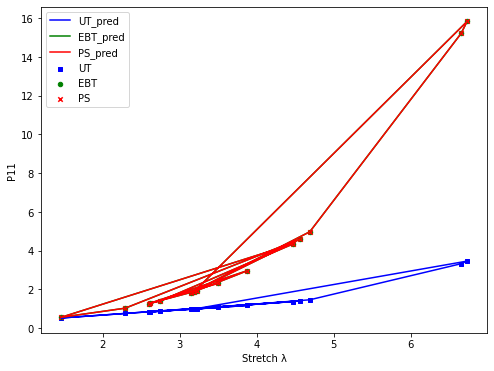

In [34]:
# Plot P11 vs Stretch for all three types of deformations
plt.figure(figsize=(8, 6))
plt.plot(stretch.numpy(), P11_ut_pred.numpy(), color="blue", linestyle="solid", label="UT_pred")
plt.plot(stretch.numpy(), P11_ebt_pred.numpy(), color="green", linestyle="solid", label="EBT_pred")
plt.plot(stretch.numpy(), P11_ps_pred.numpy(), color="red", linestyle="solid", label="PS_pred")

# The previous Graph showing actual values
# Plot P11 vs Stretch for all three types of deformations
plt.scatter(stretch, P11_ut, s=20, color="blue", marker="s", label="UT")
plt.scatter(stretch, P11_ebt, s=20, color="green", marker="o", label="EBT")
plt.scatter(stretch, P11_ps, s=20, color="red", marker="x", label="PS")
plt.xlabel("Stretch λ")
plt.ylabel("P11")
plt.legend()
plt.show()